In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.2s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Trait association

In [7]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [108]:
# Trait list
TRAIT_LIST = ['PASS_ADHD_Demontis2018', 'PASS_FastingGlucose_Manning', 'PASS_IBD_deLange2017']
TRAIT_LIST = ['PASS_FastingGlucose_Manning']
TRAIT_LIST = ['PASS_LDL', 'PASS_Alzheimers_Jansen2019']

# Tissue and tissue-cell type list
TISSUE_LIST = list(set(data_facs_ct.obs['tissue']))
TISSUE_LIST.sort()
TC_LIST = list(set(data_facs_ct.obs['tissue_celltype']))
TC_LIST.sort()
print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(TISSUE_LIST), len(TC_LIST)))

# GWAS MAGMA gene set
dic_gs = {}
for trait in TRAIT_LIST:
    # Find FDR<0.1 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    
    ind_select = (temp_df['fdr'].values<0.1)    
    dic_gs[trait] = list(temp_df.index[ind_select])
    
# Random genesets 
np.random.seed(0)
for i_gs in range(4):
    dic_gs['random%d'%i_gs] = list(np.random.choice(data_facs_ct.var_names, size=500, replace=False))
    
for trait in dic_gs.keys():
    print('# %s n_gene=%d'%(trait, len(dic_gs[trait])))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_LDL n_gene=460
# PASS_Alzheimers_Jansen2019 n_gene=298
# random0 n_gene=500
# random1 n_gene=500
# random2 n_gene=500
# random3 n_gene=500


In [133]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in dic_gs.keys():
    
    gene_list = dic_gs[trait]
    
    # mean, n_genes
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                  return_list=['trs', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_LDL                                 time=11.5s
#PASS_Alzheimers_Jansen2019               time=22.9s
#random0                                  time=34.5s
#random1                                  time=46.2s
#random2                                  time=57.7s
#random3                                  time=69.3s


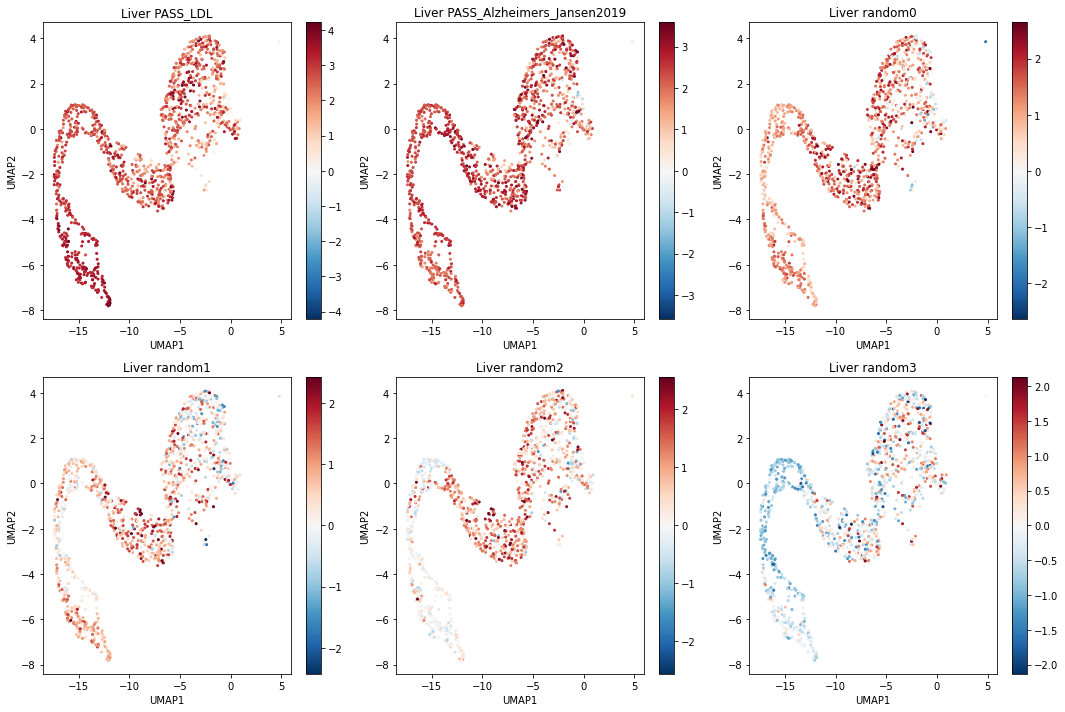

In [134]:
tissue = 'Liver'
trait_plot_list = list(dic_gs.keys())
adata_small = dic_data_facs[tissue].copy()

adata_small = adata_small[adata_small.obs['cell_ontology_class']=='hepatocyte']

df_plot = pd.DataFrame(index=adata_small.obs.index)
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
# Trait TRS plot
plt.figure(figsize=[15,10])

for i_trait,trait in enumerate(trait_plot_list):

    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)].copy()
    df_plot[trait] = temp_df.loc[df_plot.index, 'trs_ez'].copy()
#     df_plot[trait] = df_plot[trait] - df_plot[trait].mean()

    plt.subplot(2,3,i_trait+1)
    max_ = np.quantile(np.absolute(df_plot[trait].values), 0.99)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[trait],
                cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s %s'%(tissue, trait))

plt.tight_layout()
plt.show()

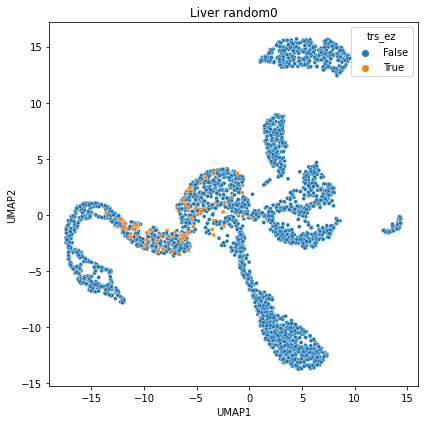

In [116]:
tissue = 'Liver'
trait = 'random0'
adata_small = dic_data_facs[tissue].copy()

df_plot = pd.DataFrame(index=adata_small.obs.index)
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]

temp_df = data_facs_ct.obs[['tissue', 'cell_ontology_class']].copy()
# temp_df['trs_ez'] = (dic_trs['%s;trs_ez'%(trait)]>1) & (temp_df['cell_ontology_class']=='myeloid cell')
temp_df['trs_ez'] = (dic_trs['%s;trs_ez'%(trait)]>2) & (temp_df['cell_ontology_class']=='hepatocyte')
df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']

plt.figure(figsize=[6,6])
max_ = np.quantile(np.absolute(df_plot['trs_ez'].values), 0.99)
sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='trs_ez', s=16)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('%s %s'%(tissue, trait))

plt.tight_layout()
plt.show()

In [117]:
cell_list = list(df_plot.index[df_plot['trs_ez']==1])
adata_small = data_facs_ct[cell_list,:].copy()
print(adata_small.shape)
md.compute_stats(adata_small)

cell_list = list(df_plot.index[df_plot['trs_ez']==0])
adata_small_ref = data_facs_ct[cell_list,:].copy()
print(adata_small_ref.shape)
md.compute_stats(adata_small_ref)

(136, 22966)
(2723, 22966)


In [118]:
adata_small.var['vst_w'] = 1 / np.sqrt(data_facs_ct.var['var_tech'].values.clip(min=1e-1))
adata_small_ref.var['vst_w'] = 1 / np.sqrt(data_facs_ct.var['var_tech'].values.clip(min=1e-1))


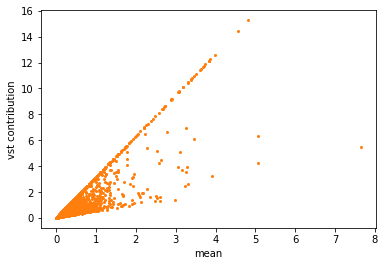

In [119]:
plt.figure()
plt.scatter(adata_small.var['mean'], adata_small.var['vst_w']*adata_small.var['mean'],
            s=4, alpha=1, color='C1')
# plt.scatter(adata_small_ref.var['mean'], adata_small_ref.var['vst_w']*adata_small_ref.var['mean'],
#             s=4, alpha=1, color='C0')
plt.xlabel('mean')
plt.ylabel('vst contribution')
plt.show()

PASS_LDL 460 425


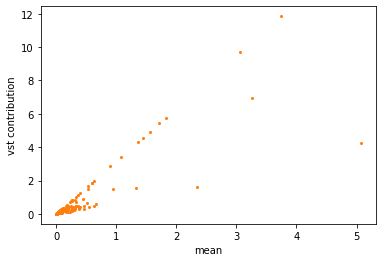

PASS_Alzheimers_Jansen2019 298 282


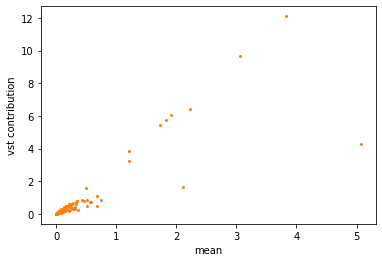

random0 500 500


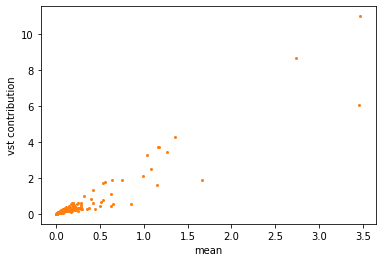

random1 500 500


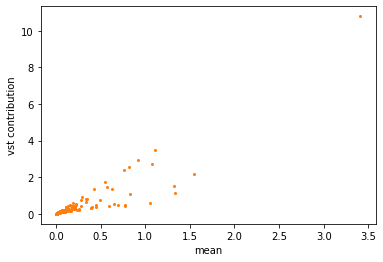

random2 500 500


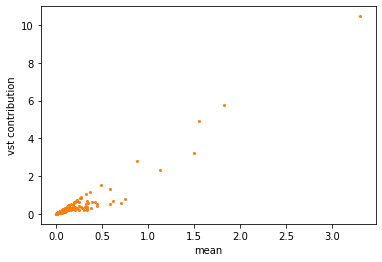

random3 500 500


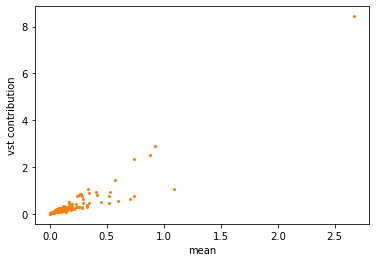

In [120]:
for gs in dic_gs.keys():
    temp_list = list(set(dic_gs[gs]) & set(adata_small.var_names))
    print(gs, len(dic_gs[gs]), len(temp_list))
    temp_adata = adata_small[:, temp_list]
    plt.figure()
    plt.scatter(temp_adata.var['mean'], temp_adata.var['vst_w']*temp_adata.var['mean'],
                s=4, alpha=1, color='C1')
    plt.xlabel('mean')
    plt.ylabel('vst contribution')
    plt.show()

In [100]:
bins_ = np.linspace(-0.1,6,20)
gene_list_plot = list(adata_small.var_names[(adata_small.var['vst_w']*adata_small.var['mean'])>2])

for gs in dic_gs.keys():
    print('# %s n_overlap=%d'%(gs, len(set(dic_gs[gs]) & set(gene_list_plot))))
    
# plt.figure(figsize=[15,15])
# for i_gene,gene in enumerate(gene_list_plot):
#     plt.subplot(np.ceil(len(gene_list_plot)/6).astype(int),6,i_gene+1)
#     plt.hist(adata_small[:,gene].X.toarray(), bins=bins_)
#     plt.title(gene)

# plt.tight_layout()
# plt.show()

# PASS_FastingGlucose_Manning n_overlap=0
# random0 n_overlap=2
# random1 n_overlap=1
# random2 n_overlap=3
# random3 n_overlap=2
# random4 n_overlap=2


In [92]:
len(gene_list_plot)

17

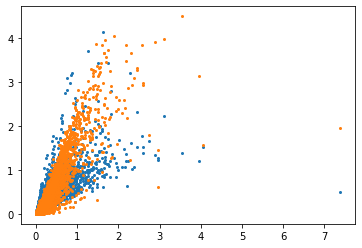

In [73]:
plt.figure()
plt.scatter(data_facs_ct.var['mean'], data_facs_ct.var['var'], s=4)
plt.scatter(data_facs_ct.var['mean'], data_facs_ct.var['var_tech'], s=4)
plt.show()

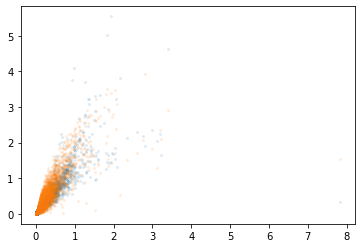

In [78]:
plt.figure()
plt.scatter(adata_small.var['mean'], adata_small.var['var'], s=4, alpha=0.1)
plt.scatter(adata_small.var['mean'], adata_small.var['var_tech'], s=4, alpha=0.1)
plt.show()

In [75]:
adata_small.var_names[adata_small.var['mean']>5]

Index(['Rn45s'], dtype='object', name='index')